## Bike Demand Prediction using Multiple Linear Regression

This notebook outlines the process of building a multiple linear regression model to predict the demand for shared bikes, including data preprocessing, feature engineering, model building, and evaluation.

### Step: Data Loading

Load the dataset and take a preliminary look at its structure.

In [1]:
import pandas as pd
import numpy as np

file_path = 'day.csv'
bike_data = pd.read_csv(file_path)

bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Step: Data Preprocessing

Handle categorical variables and check for missing values.

In [2]:
categories = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
bike_data[categories] = bike_data[categories].astype('category')

bike_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Step: Exploratory Data Analysis (EDA)

Analyze distributions and relationships between variables. Use only relevant columns for checking correlations. In this case, we're using only numeric columns and ignoring index column (instant).

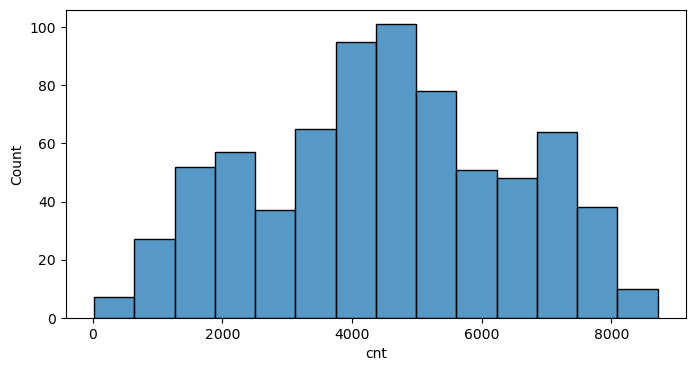

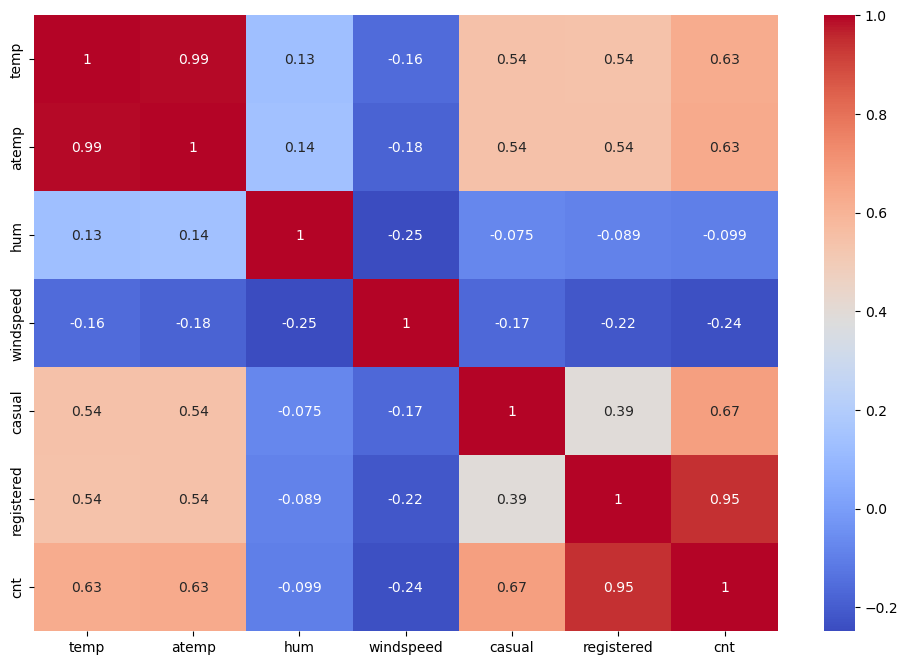

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the target variable
plt.figure(figsize=(8, 4))
sns.histplot(bike_data['cnt'])
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))

# Select only relevant numeric columns for correlation
relevant_numeric_data = bike_data.select_dtypes(include=[np.number]).drop(columns=['instant'])

# Calculate the correlation matrix
correlation_matrix = relevant_numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Observation from EDA

We see the columns 'Casual' and 'Registered' are pseudo-target variables and have high co-relation with 'Cnt' target variable. So its obvious to eliminate them from features considered.

#### Dummy Variables

Between the features 'holiday', 'weekday' and 'workingday' there is redundancy of information, as this can be reduced to just 'holiday' + 'weekday', ignoring 'workingday'.
The 'workingday' feature doesn't seem to add new information as other two features can cover it.

### Step: Feature Engineering - Manual Feature Elimination

Starting with a set of features and iteratively removing them based on high p-values and VIF.

#### Iteration 1 of Feature Removal

This is to remove features based on high p-value and recalculate VIF.

In [4]:
# Iteration-1 - Manual Feature Selection

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Initial set of features
features = ['temp', 'atemp', 'hum', 'windspeed', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit']
X = bike_data[features]
y = bike_data['cnt']

# Build a model with all features and check p-values
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

# Calculate VIF for the initial set of features
vif_data_initial = calculate_vif(X)
print(vif_data_initial)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     288.0
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          1.08e-243
Time:                        16:59:34   Log-Likelihood:                -5972.4
No. Observations:                 730   AIC:                         1.197e+04
Df Residuals:                     719   BIC:                         1.202e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1539.5341    235.339      6.542      0.0

#### Observation

Since we see high p-value for feature 'temp', we'll remove it in next iteration

#### Iteration 2 of Feature Removal

Removing 'temp' based on high p-value.

In [12]:
# Iteration-2 - Manual Feature Selection

# Iteration-2 set of features
features = ['atemp', 'hum', 'windspeed', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit']
X = bike_data[features]
y = bike_data['cnt']

# Build a model with selected features and check p-values
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

# Calculate VIF for the latest set of features
vif_data_initial = calculate_vif(X)
print(vif_data_initial)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     319.2
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          1.65e-244
Time:                        17:05:46   Log-Likelihood:                -5973.5
No. Observations:                 730   AIC:                         1.197e+04
Df Residuals:                     720   BIC:                         1.201e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1452.1707    227.588      6.381      0.0

#### Iteration 3 of Feature Removal

Removing 'mnth' based on high p-value.

In [5]:
# Iteration-3 - Manual Feature Selection

# Iteration-3 set of features
features = ['atemp', 'hum', 'windspeed', 'season', 'yr', 'holiday', 'weekday', 'weathersit']
X = bike_data[features]
y = bike_data['cnt']

# Build a model with selected features and check p-values
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

# Calculate VIF for the latest set of features
vif_data = calculate_vif(X)
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     356.2
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          1.29e-244
Time:                        16:59:34   Log-Likelihood:                -5976.3
No. Observations:                 730   AIC:                         1.197e+04
Df Residuals:                     721   BIC:                         1.201e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1461.6771    228.259      6.404      0.0

#### Iteration 4 of Feature Removal

Removed 'hum' based on high VIF.

In [14]:
# Iteration-4 - Manual Feature Selection

# Iteration-4 set of features
features = ['atemp', 'windspeed', 'season', 'yr', 'holiday', 'weekday', 'weathersit']
X = bike_data[features]
y = bike_data['cnt']

# Build a model with selected features and check p-values
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

# Calculate VIF for the latest set of features
vif_data = calculate_vif(X)
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     399.0
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          2.94e-243
Time:                        17:06:42   Log-Likelihood:                -5982.5
No. Observations:                 730   AIC:                         1.198e+04
Df Residuals:                     722   BIC:                         1.202e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        998.6560    188.197      5.306      0.0

### Step: Model Building

Build a multiple linear regression model using the latest selected features.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print(X.head()) #checking if we have latest dataset features for Model

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Build the model
model = LinearRegression()
model.fit(X_train, y_train)

      atemp  windspeed season yr holiday weekday weathersit
0  18.18125  10.749882      1  0       0       6          2
1  17.68695  16.652113      1  0       0       0          2
2   9.47025  16.636703      1  0       0       1          1
3  10.60610  10.739832      1  0       0       2          1
4  11.46350  12.522300      1  0       0       3          1


LinearRegression()

### Step: Homoscedasticity Check

A scatter plot of the residuals versus the predicted values on training set doesn't show any significant pattern for attention.

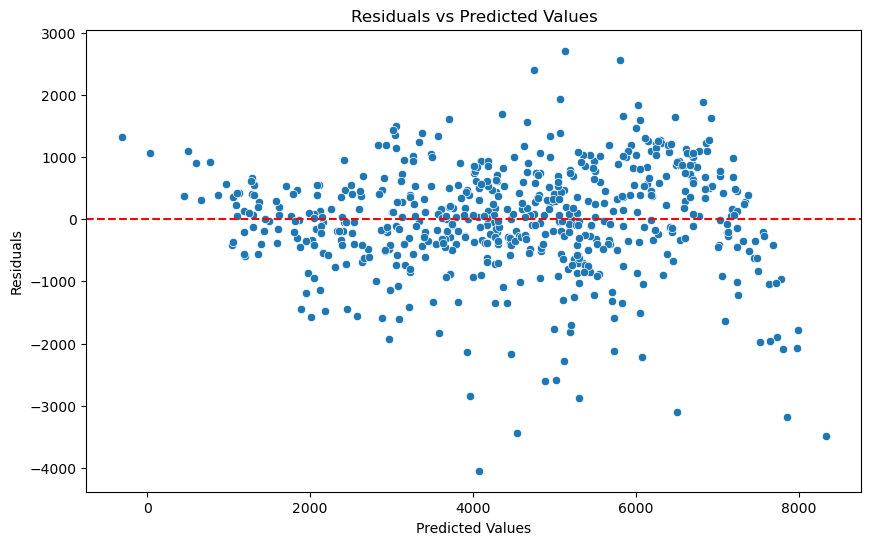

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred = model.predict(X_train)

# Calculating residuals
residuals = y_train - y_train_pred

# Plotting the residuals to check for homoscedasticity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.show()

### Step: Model Evaluation

Predict on the test set and evaluate the model.

In [16]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.7520360889013684


### Step: RFE Model Building

Contrasting the model built manually with Automatic Feature Engineering

In [10]:
from sklearn.feature_selection import RFE

# RFE Initial set of features
features_rfe_initial = ['temp', 'atemp', 'hum', 'windspeed', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
X_rfe = bike_data[features_rfe_initial]
y_rfe = bike_data['cnt']

# Recursive Feature Elimination (RFE)
model_rfe = LinearRegression()
rfe = RFE(model_rfe, n_features_to_select=7)  # Selecting top 7 features
rfe.fit(X_rfe, y_rfe)

# RFE selected features
selected_features_rfe = X_rfe.columns[rfe.support_]
print('RFE Selected Features:')
print(selected_features_rfe)

RFE Selected Features:
Index(['atemp', 'season', 'yr', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')


### Step: RFE Model Evaluation

In [17]:
# Split the data for RFE features
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe[selected_features_rfe], y, test_size=0.2, random_state=100)
model_rfe.fit(X_train_rfe, y_train_rfe)
y_pred_rfe = model_rfe.predict(X_test_rfe)
r2_rfe = r2_score(y_test_rfe, y_pred_rfe)

print(f'RFE R-squared: {r2_rfe}')

RFE R-squared: 0.7554813730329079


### Step: R-Square Comparison between Manual and RFE Strategies

##### Manual R-squared: 0.7520360889013684
##### RFE R-squared: 0.7554813730329079

Prob (F-statistic) is small enough also:          2.94e-243

As seen above, there isn't any significant change between RFE and Manual Feature Elimination.

### Conclusion

Based on the co-efficients, listed features below are influential in deciding the Shared Bikes demand.

Year, Season, Feeling Temperature and DayofWeek has positive influence. Holiday, Weather, Windspeed have negative influence.


In [21]:
# Interpretation: Coefficients of the model

# Get the coefficients from the model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Sort the coefficients by influence
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)

# Reset the index for tabular display
coefficients.reset_index(drop=True, inplace=True)

# Print the sorted coefficients table
print(coefficients)

      Feature  Coefficient
0          yr  2045.435124
1      season   381.843005
2       atemp   118.786235
3     weekday    80.602283
4   windspeed   -37.122047
5  weathersit  -794.045381
6     holiday  -835.386822
